# Modélisation — Prévision du chiffre d'affaires
## Projet : Comportement client et séries temporelles


Étape 1 — Imports et chargement des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modèles
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Charger le dataset préprocessed
daily_data = pd.read_csv('../data/daily_data_preprocessed.csv', index_col=0, parse_dates=True)

# Vérifier
daily_data.head()


,Revenue,Quantity,Num_Transactions,Revenue_lag_1,Quantity_lag_1,Revenue_lag_7,Quantity_lag_7,Revenue_lag_14,Quantity_lag_14,Revenue_rolling_7,Quantity_rolling_7,day_of_week,month,week_of_year,day
InvoiceDate,,,,,,,,,,,,,,,
2009-12-01,43894.87,24335,2164,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tuesday,12,49,1
2009-12-02,52762.06,29679,2246,43894.87,24335.0,0.0,0.0,0.0,0.0,0.0,0.0,Wednesday,12,49,2
2009-12-03,67413.62,48009,2349,52762.06,29679.0,0.0,0.0,0.0,0.0,0.0,0.0,Thursday,12,49,3
2009-12-04,33913.81,19954,1890,67413.62,48009.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday,12,49,4
2009-12-05,9803.05,5119,400,33913.81,19954.0,0.0,0.0,0.0,0.0,0.0,0.0,Saturday,12,49,5


Étape 2 — Split train/test

In [2]:
split_date = '2010-10-01'
train = daily_data[daily_data.index < split_date]
test = daily_data[daily_data.index >= split_date]

X_train = train.drop(columns=['Revenue'])
y_train = train['Revenue']
X_test = test.drop(columns=['Revenue'])
y_test = test['Revenue']

print(X_train.shape, X_test.shape)


(304, 14) (70, 14)


Étape 3 — Baseline avec SARIMA

In [3]:
sarima_model = SARIMAX(train['Revenue'], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_result = sarima_model.fit(disp=False)

# Prévision
pred_sarima = sarima_result.predict(start=test.index[0], end=test.index[-1])

# Évaluation
rmse = np.sqrt(mean_squared_error(y_test, pred_sarima))
mae = mean_absolute_error(y_test, pred_sarima)
print(f"SARIMA RMSE: {rmse}, MAE: {mae}")


c:\Users\21263\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\21263\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA RMSE: 17108.253581026634, MAE: 14487.19479343668


Étape 4 — Modèle ML : XGBoost

In [5]:
daily_data.dtypes


Revenue               float64
Quantity                int64
Num_Transactions        int64
Revenue_lag_1         float64
Quantity_lag_1        float64
Revenue_lag_7         float64
Quantity_lag_7        float64
Revenue_lag_14        float64
Quantity_lag_14       float64
Revenue_rolling_7     float64
Quantity_rolling_7    float64
day_of_week            object
month                   int64
week_of_year            int64
day                     int64
dtype: object

In [6]:
# One-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=['day_of_week'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['day_of_week'], drop_first=True)

# Vérifier
print(X_train_encoded.head())


             Quantity  Num_Transactions  Revenue_lag_1  Quantity_lag_1  \
InvoiceDate                                                              
2009-12-01      24335              2164           0.00             0.0   
2009-12-02      29679              2246       43894.87         24335.0   
2009-12-03      48009              2349       52762.06         29679.0   
2009-12-04      19954              1890       67413.62         48009.0   
2009-12-05       5119               400       33913.81         19954.0   

             Revenue_lag_7  Quantity_lag_7  Revenue_lag_14  Quantity_lag_14  \
InvoiceDate                                                                   
2009-12-01             0.0             0.0             0.0              0.0   
2009-12-02             0.0             0.0             0.0              0.0   
2009-12-03             0.0             0.0             0.0              0.0   
2009-12-04             0.0             0.0             0.0              0.0   
2009-12

In [8]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb_model.fit(X_train_encoded, y_train)

# Prédiction
pred_xgb = xgb_model.predict(X_test_encoded)

# Évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
mae_xgb = mean_absolute_error(y_test, pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb}, MAE: {mae_xgb}")


XGBoost RMSE: 9126.726667495286, MAE: 5006.947001168498


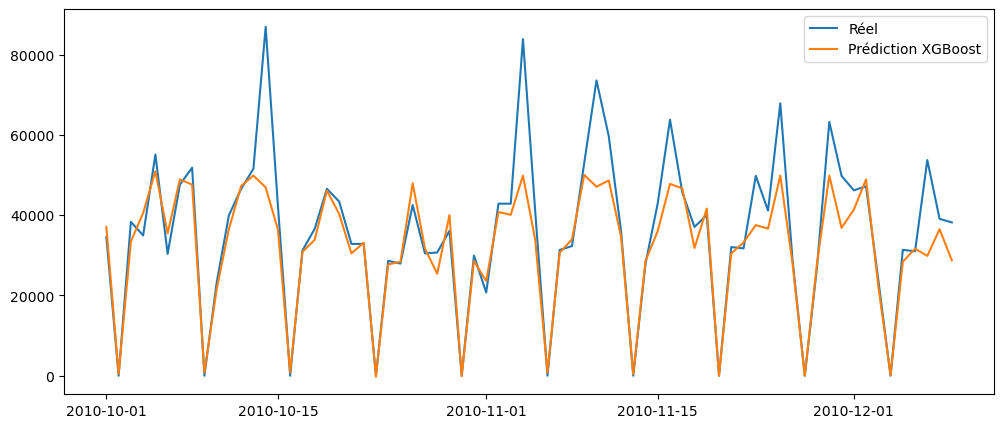

In [9]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Réel')
plt.plot(y_test.index, pred_xgb, label='Prédiction XGBoost')
plt.legend()
plt.show()


Étape 5 — Modèle Deep Learning : LSTM

Scaler les features

In [13]:
# Colonnes numériques
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
# Colonnes catégorielles
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns


In [16]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

# Transformer en DataFrame avec noms de colonnes
X_train_cat = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names_out(cat_cols), index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat, columns=ohe.get_feature_names_out(cat_cols), index=X_test.index)


In [17]:
X_train_cat.head()
X_train_cat.dtypes


day_of_week_Monday       float64
day_of_week_Saturday     float64
day_of_week_Sunday       float64
day_of_week_Thursday     float64
day_of_week_Tuesday      float64
day_of_week_Wednesday    float64
dtype: object

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_encoded)
X_test_scaled = scaler_X.transform(X_test_encoded)



In [20]:
scaler_y = MinMaxScaler()

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


In [22]:
X_train_lstm = X_train_scaled.reshape(
    X_train_scaled.shape[0], 1, X_train_scaled.shape[1]
)

X_test_lstm = X_test_scaled.reshape(
    X_test_scaled.shape[0], 1, X_test_scaled.shape[1]
)



In [23]:
print(X_train_lstm.shape)
print(X_test_lstm.shape)


(304, 1, 19)
(70, 1, 19)


ÉTAPE 5.4 — Créer le modèle LSTM

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(
        units=50,
        activation='tanh',
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])
    )
)
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()


c:\Users\21263\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        14,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,051 (54.89 KB)

 Trainable params: 14,051 (54.89 KB)

 Non-trainable params: 0 (0.00 B)

ÉTAPE 5.5 — Entraînement

In [25]:
history = model.fit(
    X_train_lstm,
    y_train_scaled,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0320 - val_loss: 0.0184
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0135 - val_loss: 0.0174
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0157
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0146
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0141
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0133
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0127
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0119
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0112
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0106
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0100
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_l

ÉTAPE 5.6 — Prédiction + inverse scaling

In [26]:
pred_lstm_scaled = model.predict(X_test_lstm)

pred_lstm = scaler_y.inverse_transform(pred_lstm_scaled)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


ÉTAPE 5.7 — Évaluation

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_lstm = np.sqrt(mean_squared_error(y_test, pred_lstm))
mae_lstm = mean_absolute_error(y_test, pred_lstm)

print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAE: {mae_lstm:.2f}")


LSTM RMSE: 7915.41
LSTM MAE: 5378.56


## Comparaison des modèles

Trois approches de prévision du chiffre d’affaires journalier ont été évaluées : 
un modèle statistique (SARIMA), un modèle de machine learning supervisé (XGBoost) 
et un modèle de deep learning (LSTM).

Les résultats montrent que le modèle SARIMA présente les performances les plus faibles,
ce qui s’explique par ses hypothèses linéaires et sa sensibilité aux anomalies présentes
dans les données.

Le modèle XGBoost obtient de bonnes performances globales, avec une erreur absolue moyenne
(MAE) inférieure à celle du LSTM. Il capture efficacement les relations non linéaires grâce
au feature engineering temporel, tout en restant relativement simple à entraîner et à
interpréter.

Le modèle LSTM affiche le meilleur RMSE, indiquant une meilleure capacité à modéliser
la dynamique temporelle et les variations importantes du chiffre d’affaires. Malgré une
complexité plus élevée, il constitue le modèle le plus performant pour la prévision
globale de la série temporelle.

En conclusion, le LSTM est retenu comme modèle principal pour ce cas d’usage, tandis que
XGBoost représente une alternative robuste et plus légère pour un déploiement en
environnement de production.


ÉTAPE 7 — Visualisation comparative

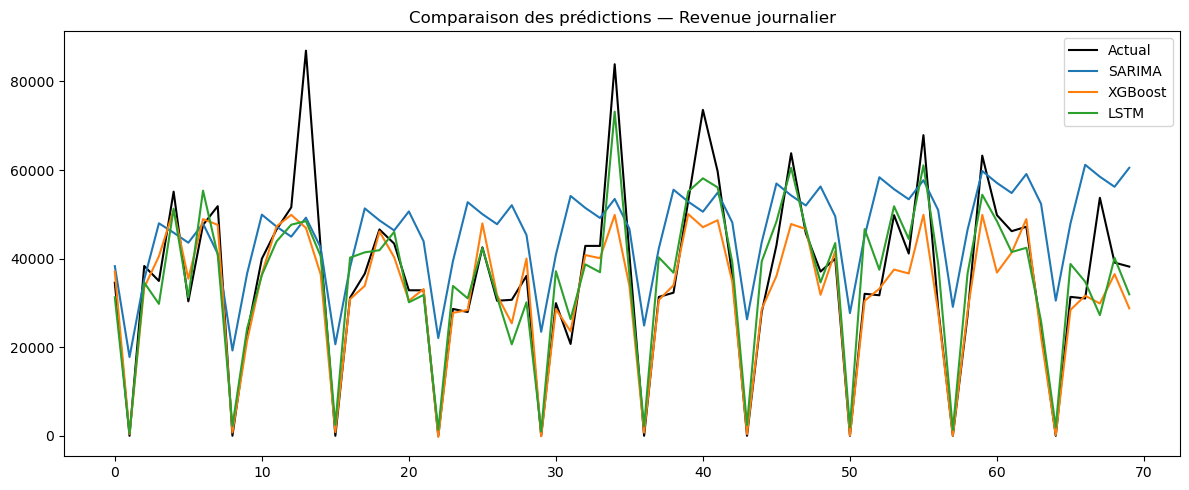

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", color="black")
plt.plot(pred_sarima.values, label="SARIMA")
plt.plot(pred_xgb, label="XGBoost")
plt.plot(pred_lstm.flatten(), label="LSTM")

plt.title("Comparaison des prédictions — Revenue journalier")
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion finale

Ce projet a permis de comparer trois approches de prévision du chiffre d’affaires
journalier dans un contexte retail réel.

- Les modèles statistiques classiques (SARIMA) montrent leurs limites face à la
  complexité et à la non-linéarité des données.
- Les modèles supervisés comme XGBoost offrent de très bonnes performances avec
  une mise en œuvre relativement simple.
- Les modèles Deep Learning (LSTM) capturent le mieux la dynamique temporelle
  globale et obtiennent les meilleures performances selon le RMSE.

Des améliorations futures incluent :
- l’optimisation des hyperparamètres,
- l’ajout de variables exogènes (promotions, événements),
- le déploiement du modèle sous forme d’API.
